In [1]:
import torch
from transformers import CamembertTokenizer, CamembertModel, CamembertForSequenceClassification, Trainer, TrainingArguments, AutoModel
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from clustertools import *

In [2]:
from importlib import reload
import clustertools
reload(clustertools)
from clustertools import *

In [3]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/bert_clusters_miso/"

# Le transformer n'a besoin que des messages bruts, pas besoin de prétraitement, celui-ci sera 
# effectué par le tokenizer
raw_dataset_file = "datasets/haine2022_oversampling_myso.txt"

### Récupération des tweets

In [4]:
with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [39]:
import random
sample_size = 5000

idx_list = random.sample(range(len(raw_dataset)), sample_size)
#clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [5]:
model_dir = "models/tweetbert"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
tokenizer = CamembertTokenizer.from_pretrained(model_dir, do_lowercase=False)
camembert = CamembertModel.from_pretrained(model_dir)

Some weights of the model checkpoint at models/tweetbert were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertModel were not initialized from the model checkpoint at models/tweetbert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
r = camembert.to(device)

In [8]:
def encode(sample):
    encoded = []
    for n in range(0, len(sample), 50):
        batch = tokenizer(sample[n:n+50], padding=True, truncation=True, max_length=512, return_tensors="pt")
        torch.cuda.empty_cache()
        batch.to(device)
        with torch.no_grad():
            outp = camembert(**batch)
        encoded.append(outp['last_hidden_state'][:,0,:].to('cpu'))
    return torch.cat(encoded)

In [9]:
%%time
dataset_encoded = encode(raw_dataset)

CPU times: user 1min 38s, sys: 1.38 s, total: 1min 39s
Wall time: 1min 40s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [10]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 2.38 s, sys: 2.75 s, total: 5.13 s
Wall time: 779 ms


In [11]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

In [12]:
init_globals([msg.split() for msg in raw_dataset], raw_dataset, two_dim_dataset, cluster_dir)

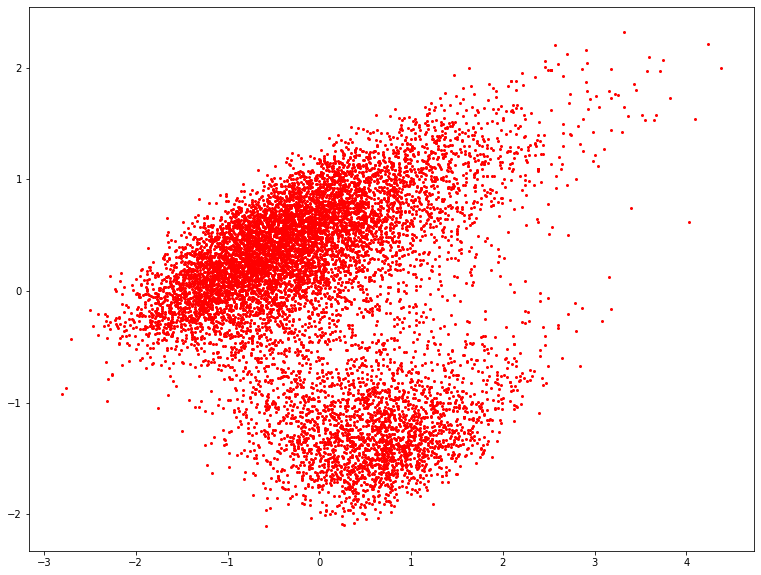

In [13]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### SOM

In [14]:
from minisom import MiniSom

In [15]:
m = 7
n = 7
som = MiniSom(m, n, 768, neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(dataset_encoded)

In [16]:
%%time
som.train(dataset_encoded, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 1.934175638010003
CPU times: user 44.8 s, sys: 2.68 s, total: 47.5 s
Wall time: 40.7 s


In [17]:
%%time
pred = []
for msg in dataset_encoded:
    winner = som.winner(msg)
    pred.append(winner[0]*n+winner[1])

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


### Analyse et sauvegarde des résultats

In [18]:
res, wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(pred)

In [19]:
classifier = CamembertForSequenceClassification.from_pretrained("models/tweetbert_FT_rand_balanced")
#torch.cuda.empty_cache()
r = classifier.to(device)

In [20]:
def predict(sample):
    pred = []
    for n in range(0, len(sample), 10):
        phrases = sample[n:n+10]
        enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
        enc.to('cuda:0')
        with torch.no_grad():
            outp = classifier(**enc)
        p = torch.nn.functional.softmax(outp.logits, dim=1)
        labels = torch.argmax(p, dim=1)
        pred.append(labels)
    return torch.cat(pred)

In [21]:
%%time 
hate_pred = []
for mlist in mlists:
    hate_pred.append(predict(mlist))

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [22]:
hper = []
for i, p in enumerate(hate_pred):
    bc = torch.bincount(p, minlength=2)
    perc = (bc[1] / (bc[0]+bc[1])).item() * 100
    hper.append(perc)

In [23]:
print_clusters_info(clust_n_msg, mfw, hkw, hper)

Cluster 0 : 123 messages
90 messages contiennent un mot-clé haineux (soit 73.17%)
91.06% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : connasse grosse va Quelle petasse grognasse sale Sale poulette Cette La gueule Connasse ! toi Moi Grosse Merci poufiasse oui 


Cluster 1 : 115 messages
91 messages contiennent un mot-clé haineux (soit 79.13%)
94.78% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : connasse petasse La grosse poufiasse Cette C poulette sale pétasse Pute oh ma Tu Quelle ! c biatch MDRR guenon 


Cluster 2 : 268 messages
227 messages contiennent un mot-clé haineux (soit 84.70%)
89.55% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : t’es toi sale ton va moi te grosse petasse connasse poulette Tu T’es mère si au fais même bien bitch 


Cluster 3 : 328 messages
273 messages contiennent un mot-clé haineux (soit 83.23%)
59.15% de messages sont détectés comme hai

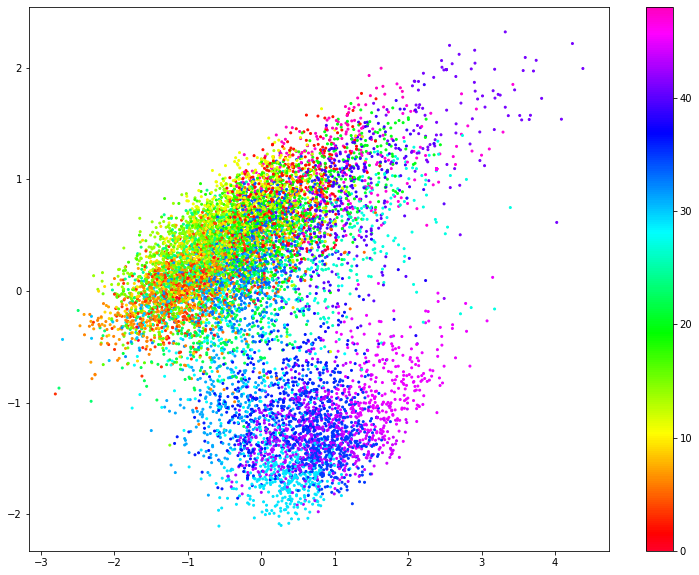

In [24]:
plot_results(pred, two_dim_dataset)

In [89]:
method = "miso_bertsom" + str(n*m)
save_clusters_msg(cmlists, mlists, e2dmlists, method)
save_clusters_info(clust_n_msg, mfw, hkw, method, hper)

### Sauvegarder le modèle et les poids

In [76]:
import pickle

dir = cluster_dir + method + "/"

In [77]:
with open(dir + 'som.p', 'wb') as outfile:
    pickle.dump(som, outfile)
    
np.save(dir + "som_weights.npy" ,som.get_weights())

### Sauvegarder les clusters encodés

In [78]:
emlists = []
for i in sorted(res):
    emlist = []
    for idx in res[i]:
        emlist.append(np.array(dataset_encoded[idx]))
    emlists.append(np.array(emlist))

In [79]:
for i, emlist in enumerate(emlists):
    np.save(dir + method + "_cluster_{}_encoded.npy".format(i), emlist)

### Test KM 2 clusters

Étant donné que la silhouette du jeu de données représenté en deux dimensions fait apparaître deux structures séparées, j'ai souhaité tester un partitionnement avec seulement 2 clusters voir s'il séparait bien les deux structures visuelles.

In [25]:
from sklearn.cluster import KMeans

In [26]:
%%time
km_model = KMeans(n_clusters=2, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 8.56 s, sys: 3.49 s, total: 12.1 s
Wall time: 2.03 s


In [27]:
%%time 
km_pred = kmeans.predict(dataset_encoded)

CPU times: user 402 ms, sys: 454 ms, total: 856 ms
Wall time: 197 ms


In [28]:
res, wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)

In [29]:
%%time 
hate_pred = []
for mlist in mlists:
    hate_pred.append(predict(mlist))

CPU times: user 1min 9s, sys: 25.3 ms, total: 1min 9s
Wall time: 1min 10s


In [30]:
hper = []
for i, p in enumerate(hate_pred):
    bc = torch.bincount(p, minlength=2)
    perc = (bc[1] / (bc[0]+bc[1])).item() * 100
    hper.append(perc)

In [31]:
print_clusters_info(clust_n_msg, mfw, hkw, hper)

Cluster 0 : 6511 messages
5473 messages contiennent un mot-clé haineux (soit 84.06%)
80.99% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : grosse connasse sale mère me va toi fait plus sa ma si avec suis petasse te bien Je se ton 


Cluster 1 : 3992 messages
2742 messages contiennent un mot-clé haineux (soit 68.69%)
48.42% de messages sont détectés comme haineux par le modèle
Les 20 mots les plus fréquents : se avec bonne plus fait me au ! ou « sa tout si même te bien son par quand sont 




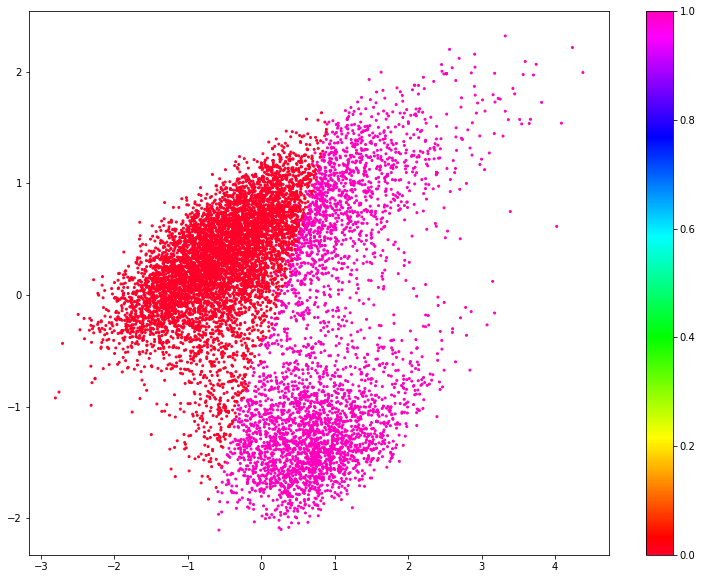

In [32]:
plot_results(km_pred, two_dim_dataset)

In [34]:
mlists[0][:50]

["Mais vous vivez dans quel monde sérieux. Une alliance RN/LFI 😂J'imagine Merluche annoncer ça au rouquin et à l'autre féministe hystérique.",
 '"il faut bien des féministe pour combattre vos féminicides, bande de mâles hystérique."',
 'Féministe hystérique va !!!!',
 "Féministe cheveux colorés = hystérique (c'est pas moi qui fait les règles)",
 'on prefere s’laisser crever seul et renaitre de ses cendres que s’faire fumer par une salope',
 'Ferme là petite salope de raciste',
 '"Salope de Delphine qui a montré son vraie visage, nous la détestons cette salope"',
 'si j’ai pas mes places pour damso jsuis une giga salope',
 'Peuple de salope ces bien connue',
 '"nn j\'ai mute le chat, il avait un deck de salope ça m\'a tilt"',
 'Hahaha admettons … vous par contre vous êtes là salope de plusieurs équipes hein mais bon hamdoulah on a jamais ramassé 8-2',
 "supprime pas c'est une salope Alexis",
 "Bztm quand c'est Benzema tu ouvres bien ta gorge salope",
 "J'en ai ma claque de cette salope"

In [35]:
mlists[1][:100]

['content',
 '"Cette censure est incroyable Gregory Roose s adresse à une féministe hystérique dans l’excès pas à des personnes souffrant d handicap en quoi il y a un comportement haineux en raison d un handicap, c juste parce qu il dit qu elle est déficiente mentale, on marche sur la tête"',
 '"""hystérique c\'est mysogine"" va vraiment que tu arrête ce complexe d\'infériorité.Tu es féministe ? OK. Tu veux l\'égalité ? Normal. Alors pq tu veux déjà un traitement différent d\'un homme ?Quand un mec est hystérique on ne va pas changer la définition du mot pr ta pomme."',
 '"Je suis pas une neo féministe hystérique mais y’a des hommes déconnectés du réel, j’me suis faite caillassée dans un parc à Aix en Provence « où genre ça craint pas » et bien d’autres choses encore… alors imaginez ailleurs."',
 '"Mais ferme ta gueule la féministe hystérique, si la marque dit qu\'elle était pas sortit elle c\'est mieux que toi, et que tes preuves twitter, déjà mettre preuves et Twitter dans la même ph

### Prédiction sur l'ensemble du premier jeu de données avec le modèle de validation

In [288]:
raw_dataset_file = "datasets/MillionTweets_NEFU.txt"
with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

In [301]:
def predict(sample):
    pred = []
    lensample = len(sample)
    step = 100
    for n in range(0, lensample, step):
        print("{:.2f}%".format((n/lensample)*100), end='\r')
        phrases = sample[n:n+step]
        enc = tokenizer(phrases, padding=True, truncation=True, max_length=512, return_tensors='pt')
        enc.to('cuda:0')
        with torch.no_grad():
            outp = classifier(**enc)
        p = torch.nn.functional.softmax(outp.logits, dim=1)
        labels = torch.argmax(p, dim=1)
        pred.append(labels)
    return torch.cat(pred)

In [302]:
%%time
full_hate_pred = predict(raw_dataset)

CPU times: user 2h 37min 29s, sys: 0 ns, total: 2h 37min 29s
Wall time: 2h 37min 33s


#### On regarde à quoi ressemblent les messages haineux

In [305]:
fhp = np.array(full_hate_pred.to('cpu'))

In [314]:
h_idxs = [i for (i, lab) in enumerate(fhp) if lab == 1]

In [318]:
for idx in h_idxs[:100]:
    print(raw_dataset[idx])

Meufff😻
Maes tiakola Zed dans un même son ?
C.....PALO
Ftg toi sinon j'debarque à Levallois
la France n'existe plus depuis que macron est la dites Europe ça ira plus vite il est grand temps que ce gars dégage ça urge
pose pas de questions
se foutre de la gueule et participer au harcèlement de féministes pour se constituer un public de simps fachos qui puent des pieds
Les camerounais ils se comportent comme s'ils étaient directement qualifiés pour le mondial !Il ya encore les barrages les gars ! Rien n'est fait calmez vous ! 😄
Tu as du flow mon grand, juste va falloir commencer a arrêter de mettre des coupes comme ça
Les geniteurs des futures équipes de football algériennes et marocaines. https://t.co/2j1iyMM9xD
Boffum 🥺
Juste macron avec un masque FaceApp
Qu'elle tombe de son siège
L’ogre danois bien sûr
Ce qu on a conteste. En Espagne. Il mangeait tt seul. Papa dit ça. Il se fait lyncher par FC zemour 2022. Sr Tweeter.
On fait couler le sang de qui ont veut on est d barbare mm ya quoi

In [310]:
np.save("datasets/MillionTweets_NEFU_labels.npy", fhp)